In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sounddevice as sd

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
import mdct
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel, svd
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
from scipy.linalg import hankel, svd

# Useful functions

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [4]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [199]:
wavefile = load_sound('clocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [201]:
play = False
if play :
    play_sound('clocheB.WAV')

In [7]:
T, data, nframes, nchannels, sampling_frequency = read_values('clocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

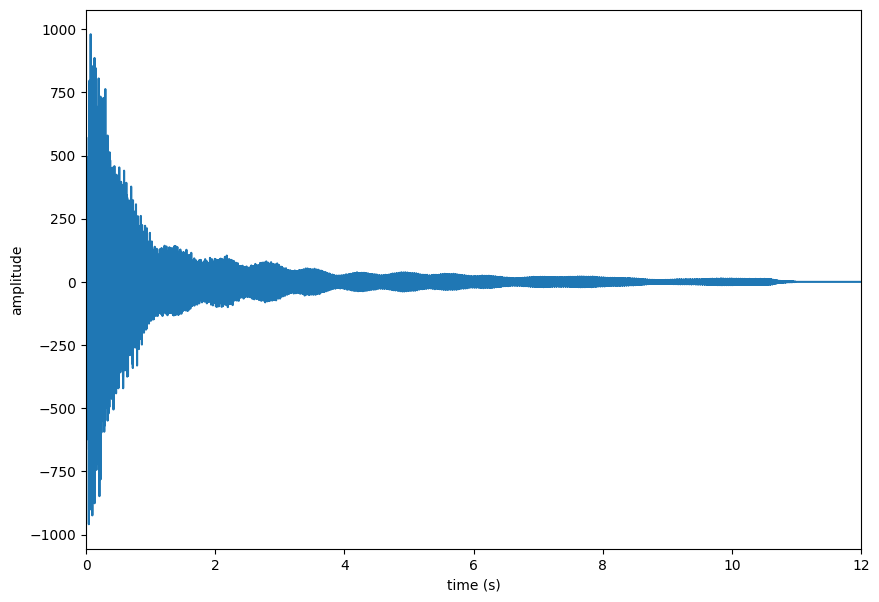

In [8]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [9]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

# 3. Signal Synthétique

In [10]:
# Paramètres
N = 63
f0 = 1/4
f1 = f0 + 1/N
a0 = 1
a1 = 10
delta0 = 0
delta1 = -0.05

In [11]:
rng = np.random.default_rng()

f = np.array([f0, f1])
a = np.array([a0, a1])
delta = np.array([delta0, delta1])
phi = rng.uniform(low=0.0, high=2*np.pi, size=2)
print(phi)

[0.64624684 1.46442627]


In [12]:
x = Synthesis(N, delta, f, a, phi)

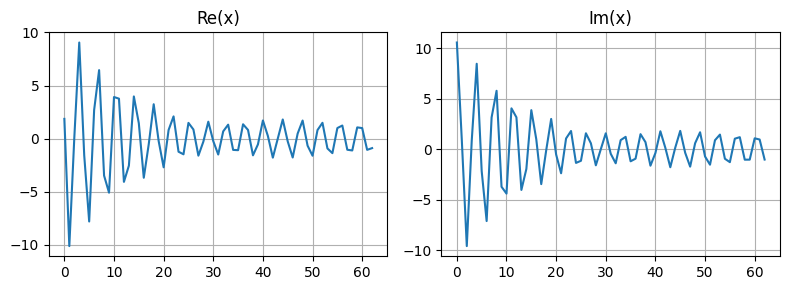

In [13]:
fig = plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.real(x))
plt.title("Re(x)")
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.imag(x))
plt.title("Im(x)")
plt.grid()
fig.tight_layout()

plt.show()

## 3.1. Analyse spectrale par transformation de Fourier

In [14]:
# Périodogramme du signal
from scipy.signal import periodogram
from scipy.fft import fft, ifft

In [42]:
# Nfft = N
# X = fft(x, Nfft)
# f = np.linspace(0, 1, Nfft, endpoint=False)

# Nfft_zero_padding = 1024
# X_zero_padding = fft(x, Nfft_zero_padding)
# f_zero_padding = np.linspace(0, 1, Nfft_zero_padding, endpoint=False)

# plt.figure()
# plt.subplot(2,1,1)
# plt.title('Nfft = N')
# plt.plot(f, 20*np.log10(np.abs(X)))
# plt.xlabel('f (normalized)')
# plt.ylabel('$|X(f)| (dB)$')

# plt.subplot(2,1,2)
# plt.title('Nfft = 8*N')
# plt.plot(f_zero_padding, 20*np.log10(np.abs(X_zero_padding)))
# plt.xlabel('f (normalized)')
# plt.ylabel('$|X(f)| (dB)$')
# plt.tight_layout()

In [43]:
freqs, Pxx = periodogram(x, nfft=N, return_onesided=False)
freqs_with_padding, Pxx_with_padding = periodogram(x, nfft=1024, return_onesided=False)

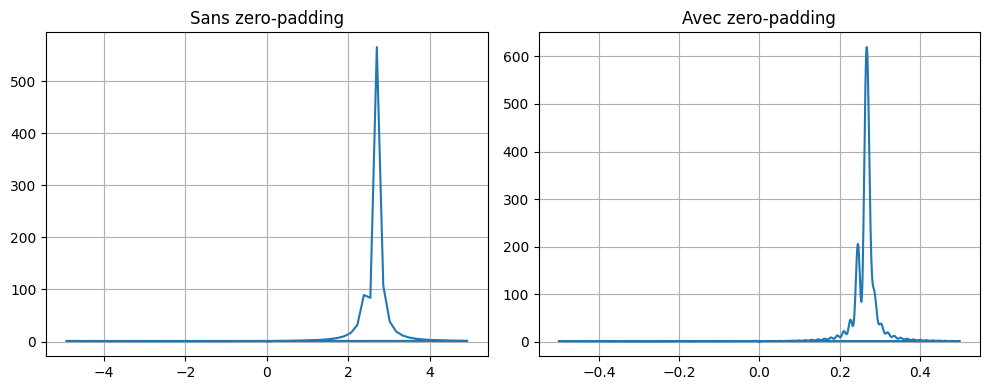

In [44]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(10*freqs, Pxx)
plt.title("Sans zero-padding")
plt.grid()

plt.subplot(1,2,2)
plt.plot(freqs_with_padding, Pxx_with_padding)
plt.title("Avec zero-padding")
plt.grid()
fig.tight_layout()

plt.show()

Les deux raies sont mieux séparables lorsque l'on effectue un zero-padding.

Selon les valeurs des $\phi_k$, les deux raies sont parfois indistinguables sur le périodogramme sans zero-padding, en particulier quand les phases initiales des deux exponentielles complexes sont proches. Dans ce cas, les interférences sont constructives et il est donc difficile de distinguer les 2 fréquences.

## 3.2. Méthodes à haute résolution

In [45]:
# Dimensions
K = 2
n = 32
l = N - n + 1

1. Calcul de la matrice de corrélation

In [46]:
def auto_corr(x, n):
    N = len(x)
    l = N + 1 - n
    X = hankel(x[:n], x[n-1:])
    R = 1/l * X@X.conj().T
    return R

In [47]:
Rxx = auto_corr(x, n)
print(Rxx.shape)

(32, 32)


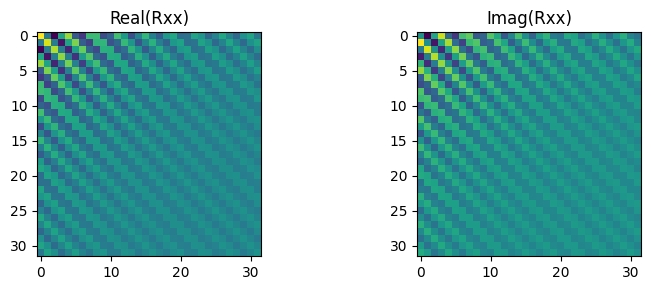

In [50]:
fig = plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.imshow(np.real(Rxx))
plt.title("Real(Rxx)")
plt.subplot(1,2,2)
plt.imshow(np.imag(Rxx))
plt.title("Imag(Rxx)")

fig.tight_layout()
plt.show()

2. Estimation de l’espace signal

In [51]:
U1, Lambda, U2 = np.linalg.svd(Rxx)
print(U1.shape, Lambda.shape, U2.shape)

(32, 32) (32,) (32, 32)


In [52]:
print(Lambda)

[2.59535775e+02 1.51287457e+01 5.95152691e-14 2.43825906e-14
 2.43825906e-14 2.43825906e-14 2.43825906e-14 2.43825906e-14
 2.43825906e-14 2.43825906e-14 2.43825906e-14 2.43825906e-14
 2.43825906e-14 2.43825906e-14 2.43825906e-14 2.43825906e-14
 2.43825906e-14 2.43825906e-14 2.43825906e-14 2.43825906e-14
 2.43825906e-14 2.43825906e-14 2.43825906e-14 2.43825906e-14
 2.43825906e-14 2.43825906e-14 2.43825906e-14 2.43825906e-14
 2.43825906e-14 2.43825906e-14 2.43825906e-14 2.03886464e-14]


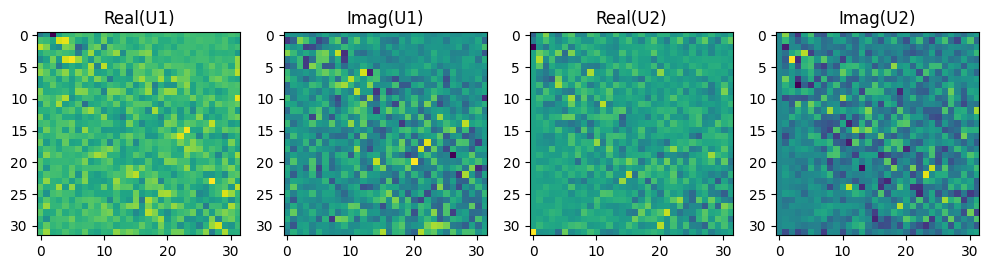

In [53]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,4,1)
plt.imshow(np.real(U1))
plt.title("Real(U1)")
plt.subplot(1,4,2)
plt.imshow(np.imag(U1))
plt.title("Imag(U1)")

plt.subplot(1,4,3)
plt.imshow(np.real(U2))
plt.title("Real(U2)")
plt.subplot(1,4,4)
plt.imshow(np.imag(U2))
plt.title("Imag(U2)")

fig.tight_layout()
plt.show()

#### Remarque sur les vecteurs propres

On observe effectivement que les vecteurs propres de l'espace signal oscillent avec une pseudo période claire, tandis que ceux de l'espace bruit... sont du bruit.

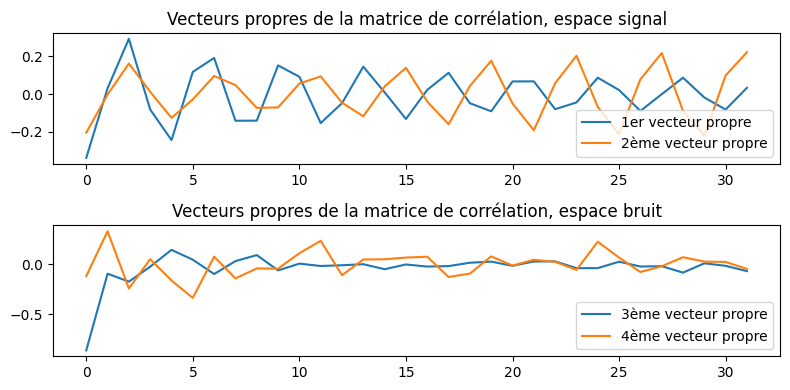

In [57]:
fig = plt.figure(figsize=(8,4))
plt.subplot(2,1,1)

plt.plot(np.real(U1[:,0]), label='1er vecteur propre')
plt.plot(np.real(U1[:,1]), label='2ème vecteur propre')
plt.legend()
plt.title('Vecteurs propres de la matrice de corrélation, espace signal')

plt.subplot(2,1,2)
plt.title('Vecteurs propres de la matrice de corrélation, espace bruit')
plt.plot(np.real(U1[:,2]), label='3ème vecteur propre', alpha=1)
plt.plot(np.real(U1[:,3]), label='4ème vecteur propre', alpha=1)
plt.legend()
fig.tight_layout()
plt.show()

In [58]:
W = U1[:,:K].copy()
print(W.shape)

(32, 2)


### 3.2.1. Algorithme ESPRIT

3. Estimation des fréquences et des facteurs d’amortissement

In [59]:
def ESPRIT(x, n, K):
    X = hankel(c=x[:n], r=x[n-1:N])
    Rxx = (1/l) * np.matmul(X, X.conj().T)
    U1, Lambda, U2 = np.linalg.svd(Rxx)
    W = U1[:,:K].copy()
    W_dn = W[:-1,:]
    W_up = W[1:,:]
    Phi = np.matmul(np.linalg.pinv(W_dn), W_up)
    z, _ = np.linalg.eig(Phi)
    d = np.log(np.abs(z))
    f = (1/(2*np.pi))*np.angle(z)
    return d, f

In [60]:
def LeastSquares(x, delta, f):
    N = len(x)
    K = len(delta)
    t = np.arange(N)[:, np.newaxis]
    V = np.exp(np.matmul(t, delta[np.newaxis,:] + 1j*2*np.pi*f[np.newaxis,:]))
    alpha = np.matmul(np.linalg.pinv(V), x)
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

4. Estimation des amplitudes et des phases

In [61]:
d, f = ESPRIT(x, n, K)

In [62]:
a, phi = LeastSquares(x, d, f)

In [63]:
x_hat = Synthesis(N,d,f,a,phi)

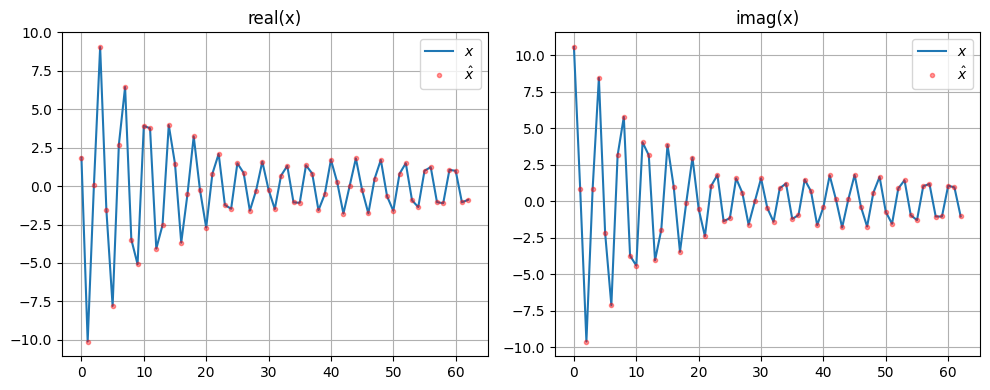

In [64]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(np.real(x))
plt.plot(np.real(x_hat), 'r.', alpha=0.4)
plt.title("real(x)")
plt.legend(['$x$', '$\hat{x}$'])
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.imag(x))
plt.plot(np.imag(x_hat), 'r.', alpha=0.4)
plt.title("imag(x)")
plt.legend(['$x$', '$\hat{x}$'])
plt.grid()
fig.tight_layout()

plt.show()

5. Application aux signaux synthétiques

In [75]:
print(f"Vrai f:\t\t{[1/4, 1/4+1/N]}")
print(f"Estimation:\t{f}")
print("")
print(f"Vrai delta:\t{[0, -0.05]}")
print(f"Estimation:\t{d}")

Vrai f:		[0.25, 0.26587301587301587]
Estimation:	[0.26587302 0.25      ]

Vrai delta:	[0, -0.05]
Estimation:	[-5.0000000e-02  4.4408921e-16]


Le signal synthétique `x` est reconstruit très fidèlement, ses paramètres sont estimés avec une grande précision.

### 3.2.2. Méthode MUSIC

6. Affichage du pseudo-spectre MUSIC

In [76]:
# def MUSIC(x,n,K):            
#     N = len(x)
#     l = N - n + 1
#     nb = 501
#     f = np.linspace(0.2, 0.3, nb)
#     d = np.linspace(-0.07, 0.01, nb)
    
#     X = hankel(c=x[:n], r=x[n-1:N])
#     Rxx = (1/l) * np.matmul(X, X.conj().T)
#     U1, _, _ = np.linalg.svd(Rxx)
#     W1 = U1[:,K:].conj().T    
    
#     pz_matrix = np.zeros((len(d), len(f)))
#     for i, di in enumerate(d):
#         for j, fj in enumerate(f):
#             z = np.exp(di + 1j*2*np.pi*fj)
#             vz = np.stack([z**k for k in range(n)]).flatten()
#             pz = 1/np.linalg.norm(np.matmul(W1,vz), axis=0)
#             pz_matrix[i][j] = pz
            

In [34]:
my_norm = lambda x: (np.sum(np.abs(x)**2))

In [77]:
def MUSIC(x, n, K):
    
    n_points = 250

    f = np.linspace(-0.05, 0.05, n_points)
    d = np.linspace(-0.1, 0.1, n_points)
    f_grid, d_grid = np.meshgrid(f, d)

    Rxx = auto_corr(x, n)

    U1, _, _ = svd(Rxx)

    Wortho = U1[:, K:]

    P = np.zeros((n_points,n_points))

    for i in range(n_points):
        for j in range(n_points):
            z = np.exp(d[i] + 2*1j*np.pi*f[j])
            v = np.array([z**(k) for k in range(n)])
            temp = np.dot(Wortho.conj().T, v)
            temp2 = np.sum(np.abs(temp)**2)
            P[i,j] = 1/temp2

    P /= np.max(np.abs(P))

    # Créer une figure 3D
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')

    # Tracer la surface
    ax.plot_surface(f_grid, d_grid, P, cmap='viridis')

    # Ajouter des étiquettes aux axes
    ax.set_xlabel('$f$', fontsize='large')
    ax.set_ylabel('$\delta$', fontsize='large')
    ax.set_zlabel('$P$', fontsize='large')
    ax.set_title("MUSIC Algorithm", fontsize='x-large')

    # Afficher le graphique
    fig.tight_layout()
    plt.show()

    return P, f_grid, d_grid

In [111]:
def MUSIC_2(x, n, K):
    # Compute the covariance matrix
    Rxx = auto_corr(x, n)
    
    # Get the eigen vectors
    U1, _, _ = svd(Rxx)
    W = U1[:,:K]
    W_ort = U1[:,K:]
    
    # Span across delta and f
    delta = np.linspace(-.1, .1, 500)
    f = np.linspace(0, 1, 500)
    z = np.exp(delta[:, np.newaxis] + 1j*2*np.pi*f[np.newaxis, :])
    
    vn_z = np.stack([z**i for i in range(n)], axis=1)
    
    W_ort_2 = W_ort.conj().T[np.newaxis,:,:]

    temp = np.matmul(W_ort_2,vn_z)

    P_z = 1/(np.linalg.norm(temp, axis=1)**2)

    # Plot the surface
    delta, f = np.meshgrid(delta, f)
    fig = plt.figure(figsize=(8,8))
    ax = fig.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(delta, f, np.log(P_z), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_xlabel('$\delta$', fontsize=18)
    ax.set_ylabel('$f$', fontsize=18)
    ax.set_title("Méthode MUSIC", fontsize=22)
    fig.tight_layout()
    plt.show()
    
    return P_z, delta, f

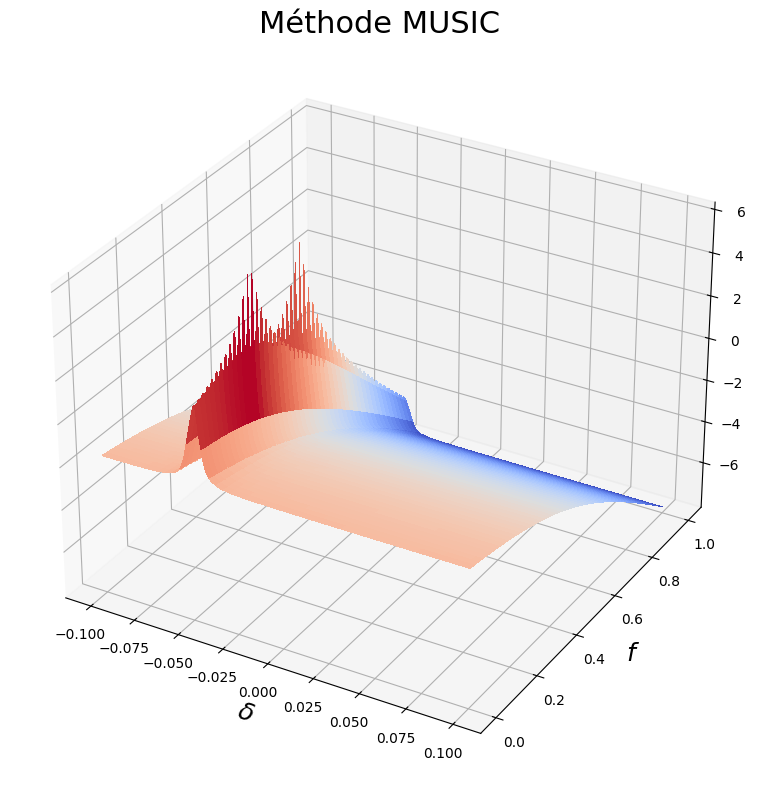

In [112]:
P_z, d_grid, f_grid = MUSIC_2(x, n, K)

# 4. Signaux Audio

## 4.1. Analyse spectrale par transformation de Fourier

In [166]:
filename = "clocheA.WAV"
wavefile = load_sound(filename)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=95997, comptype='NONE', compname='not compressed')


In [167]:
T, data, nframes, nchannels, sampling_frequency = read_values(filename)
Fs = int(wavefile.getframerate())
x = np.array(data).flatten()
num_samples = int(wavefile.getnframes())

In [168]:
play = True
if play :
    play_sound(filename)

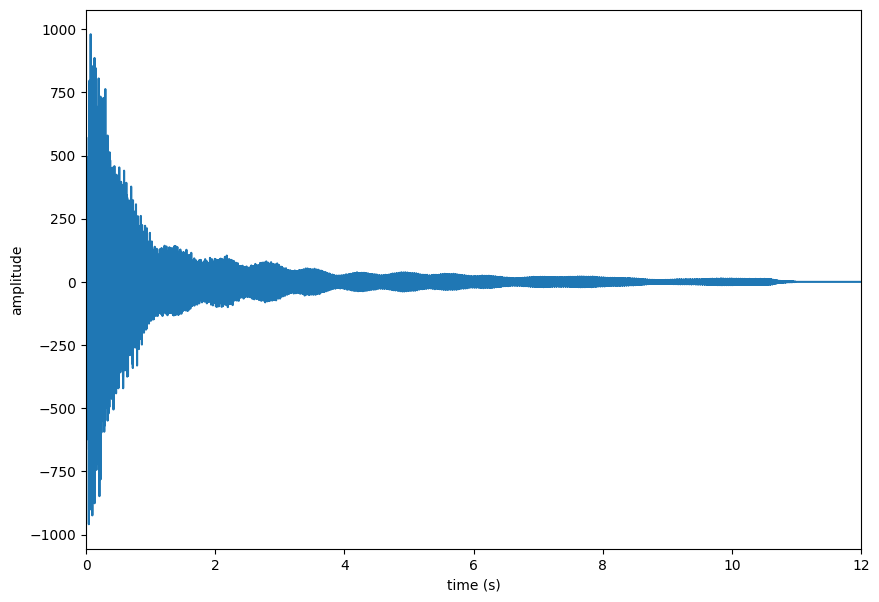

In [169]:
len_x = len(x)
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [170]:
freqs_with_padding, Pxx_with_padding = periodogram(x, nfft=1024, return_onesided=True)

In [178]:
f0 = freqs_with_padding[np.argmax(Pxx_with_padding)]
print(f"Fondamental:\t{round(f0*Fs,2)}Hz")

Fondamental:	867.19Hz


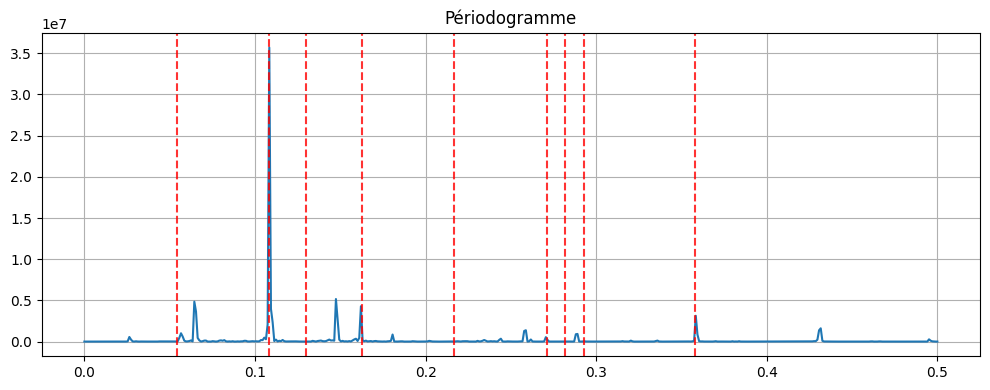

In [183]:
fig = plt.figure(figsize=(10,4))

# Périodogramme
plt.plot(freqs_with_padding, Pxx_with_padding)

# Partiels attendus
plt.axvline(f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(0.5*f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(1.2*f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(1.5*f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(2*f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(2.5*f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(2.6*f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(2.7*f0, color='r', linestyle='--', alpha=0.8)
plt.axvline(3.3*f0, color='r', linestyle='--', alpha=0.8)

plt.title("Périodogramme")
plt.grid()
fig.tight_layout()

plt.show()

La série de fréquences propres est sensiblement différente de ce que l'on attendait.  
Plusieurs partiels attendus (ex. $1.2f_0$) sont absents, et des partiels inattendus sont présents (ex. $\sim 1.36f_0$).

## 4.2. Méthode à haute résolution

In [184]:
K = 54
n = 512
l = 2*n
N = n + l - 1

In [189]:
x_cut = x[10000: 10000+N]

In [190]:
d, f = ESPRIT(x_cut, n, K)
a, phi = LeastSquares(x_cut, d, f)

In [191]:
x_hat = Synthesis(N,d,f,a,phi)

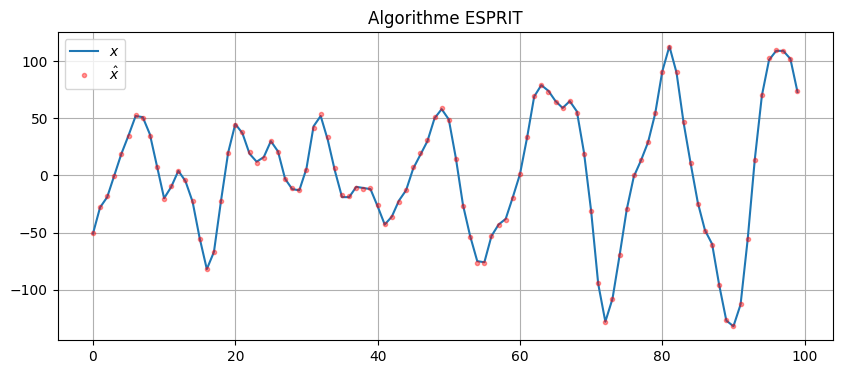

In [197]:
fig = plt.figure(figsize=(10,4))

plt.plot(np.real(x_cut[:100]))
plt.plot(np.real(x_hat[:100]), 'r.', alpha=0.4)
plt.title("Algorithme ESPRIT")
plt.legend(['$x$', '$\hat{x}$'])
plt.grid()

plt.show()

In [246]:
x_hat.shape

(10000,)

In [242]:
x_sound = np.real(np.concatenate([x_hat] * 5))

In [245]:
x_sound.shape

(50000,)

In [243]:
write('new_bell.WAV', Fs, np.array(x_sound, dtype=np.int16)) # to write a new wave file

In [244]:
play = True
if play :
    play_sound("new_bell.WAV")